In [1]:
import os, sys, glob
import logging
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

from signal_generator import SignalGenerator
from background_generator import BackgroundGenerator
from utils import bin_to_healpix

In [2]:
public_data_directory = "../gxn/gXn_simulations/icecube_10year_ps/"

aeffs = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_effectiveArea.csv")))
smearing = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_smearing.csv")))
uptime = [os.path.join(public_data_directory, "uptime/IC86_II_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_III_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_IV_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_V_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VI_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VII_exp.csv")]
data = [os.path.join(public_data_directory, "events/IC86_II_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_III_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_IV_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_V_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VI_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VII_exp.csv")]

x = SignalGenerator(aeffs, smearing, uptime,
                    angular_resolution_scale=1.0)
y = BackgroundGenerator(data)


/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:116: RuntimeWarning: divide by zero encountered in log
  - np.cos(np.radians(smearing['AngErr_max[deg]'])))))


In [3]:
def powerlaw_integral_flux(emin, emax, normalization=1e-13, E0=1000, index=-2):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral
transfer, N_expected =x.get_expectations(10, 
                                         0,
                                         powerlaw_integral_flux)
transfer = transfer[N_expected>0]
N_expected = N_expected[N_expected>0]

llh_table = np.log(N_expected.values / N_expected.sum())

print(N_expected.values)
print(N_expected.values / N_expected.sum())
print(llh_table)

#print(N_expected.shape, np.count_nonzero(N_expected))
#print(len(transfer), transfer.columns)

[7.98145954e-06 3.99088175e-06 3.99088175e-06 ... 5.11858347e-05
 3.41245239e-05 1.70620717e-05]
[6.87473548e-09 3.43749865e-09 3.43749865e-09 ... 4.40883114e-08
 2.93927538e-08 1.46962130e-08]
[-18.79541267 -19.48852177 -19.48852177 ... -16.93707114 -17.34251766
 -18.03567599]


In [4]:
import time
import numba

loge = np.concatenate([transfer['log10(E/GeV)_min'], transfer['log10(E/GeV)_max']])
loge_bins = np.unique(loge)
sigma = np.concatenate([transfer['AngErr_min[deg]'], transfer['AngErr_max[deg]']])
sigma_bins = np.unique(sigma)
sigma, sigma_bins = np.radians(sigma), np.radians(sigma_bins)
psf = np.concatenate([transfer['PSF_min[deg]'], transfer['PSF_max[deg]']])
psf_bins = np.unique(psf)
psf, psf_bins = np.radians(psf), np.radians(psf_bins)
weights = np.concatenate([llh_table, -llh_table])

start = time.time()
table, bins = np.histogramdd([loge, sigma, psf],
                                 bins = [loge_bins, sigma_bins, psf_bins],
                                 weights = weights)
#table = np.cumsum(table, axis=0).cumsum(axis=1).cumsum(axis=2)
end = time.time()
print(end-start)
print(table.min(), table.max())

0.07380390167236328
-19.488521767123558 35.37819365657352


In [5]:
@numba.njit(cache=True, fastmath=True)
def logaddexp(a, b):
    if b == -np.inf: return a
    if a == -np.inf: return b
    if b-a > 3: return b
    if a-b > 3: return a
    m = max(a,b)
    return np.log(np.exp(a-m)+np.exp(b-m))
    
@numba.njit(cache=True, fastmath=True, parallel=True)
def histogram3d(values, loge_bins, sigma_bins, psf_bins, weights):
    hist = np.ones((len(loge_bins), len(sigma_bins), len(psf_bins))) * -np.inf
    shape = hist.shape
    
    for m in range(values.shape[1]):
        a = np.searchsorted(loge_bins, values[0,m], side='right')-1
        b = np.searchsorted(sigma_bins, values[1,m], side='right')-1
        c = np.searchsorted(psf_bins, values[2,m], side='right')-1
        hist[a,b,c] = logaddexp(hist[a,b,c], weights[m])

    #dloge = np.log(np.diff(loge_bins))
    #dsigm = np.log(2*np.pi * -np.diff(np.cos(sigma_bins)))
    #dpsf = np.log(2*np.pi * -np.diff(np.cos(psf_bins)))
            
    for i in range(1, shape[0]):
        for j in numba.prange(shape[1]):
            for k in numba.prange(shape[2]):
                hist[i,j,k] = logaddexp(hist[i,j,k], hist[i-1,j,k])
    for i in numba.prange(shape[0]):
        for j in range(1, shape[1]):
            for k in numba.prange(shape[2]):
                hist[i,j,k] = logaddexp(hist[i,j,k], hist[i,j-1,k])
        for j in numba.prange(shape[1]):
            for k in range(1, shape[2]):
                hist[i,j,k] = logaddexp(hist[i,j,k], hist[i,j,k-1])
                    
    return np.exp(hist)

Text(0,0.5,'sin($\\delta$)')

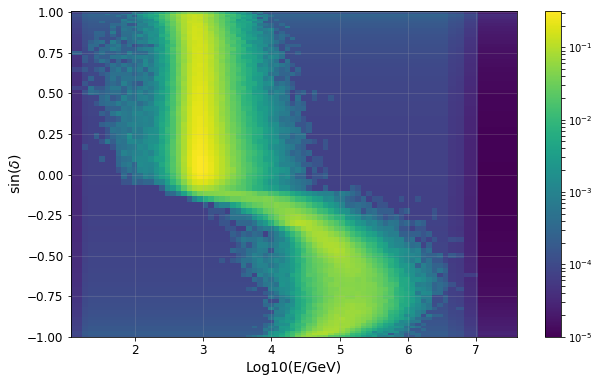

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
cmesh = ax.pcolormesh(y.loge_bins, y.sindec_bins, y.pdf_histogram.T,
                      norm=LogNorm())
plt.colorbar(cmesh, ax=ax)

ax.grid(alpha=0.25)
ax.tick_params(labelsize=12)
ax.set_xlabel(r"Log10(E/GeV)", fontsize=14)
ax.set_ylabel(r"sin($\delta$)", fontsize=14)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


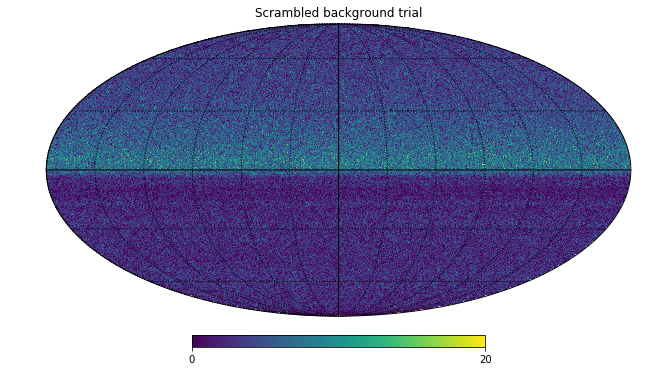

In [7]:
bg_events = y.scramble()
event_map = bin_to_healpix(128, np.degrees(bg_events['ra']), np.degrees(bg_events['dec']))
hp.mollview(event_map, flip='geo', title='Scrambled background trial')
hp.graticule(coord='E',)

In [8]:
def sob(events, new=False):
    if new:
        S = x.pdf_pointsource(events,
                              declination_deg = dec_deg, 
                              right_ascension_deg = ra_deg,
                              integral_flux_function = powerlaw_integral_flux,
                              new=new)
        Snllh = -1*np.log(S)
        Bnllh = -1*y.logpdf(events['logE'], np.sin(events['dec']))
    else:
        Snllh = -1*x.pdf_pointsource(events,
                                  declination_deg = dec_deg, 
                                  right_ascension_deg = ra_deg,
                                  integral_flux_function = powerlaw_integral_flux,
                                  new=new)
        Bnllh = -1 * y.logpdf(events['logE'], np.sin(events['dec']))
    logsob = -Snllh
    #print('S', np.sort(Snllh))
    #print('B', np.sort(Bnllh))
    return logsob

def trim(events, angle=5):
    query_string = (f"(({np.radians(dec_deg-angle)} < dec < {np.radians(dec_deg+angle)})"
                    f" & ({np.radians(ra_deg-angle)} < ra < {np.radians(ra_deg+angle)}))")
    return events.query(query_string)


In [9]:
def powerlaw_integral_flux(emin, emax, normalization=1e-13, E0=1000, index=-2):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

dec_deg, ra_deg = 0, 10
signal = x.generate_pointsource(declination_deg = dec_deg, 
                                right_ascension_deg = ra_deg,
                                integral_flux_function = powerlaw_integral_flux)
background = y.scramble()

new = True
signal = trim(signal)
background = trim(background)

signal_sob = sob(signal, new)
background_sob = sob(background, new)

-34215.870053662096
-22748.572175579786
1254 1254


Text(0.5,0,'log(S/B)')

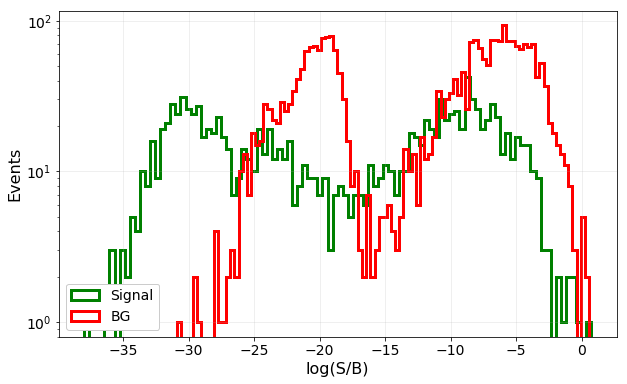

In [10]:
llh_bins = 100#np.linspace(-5, 10, 20)
fig, ax = plt.subplots(figsize=(10,6))

print(background_sob.sum())
print(signal_sob.sum())
print(np.isfinite(signal_sob).sum(), len(signal_sob))

ax.hist(signal_sob,
        bins=llh_bins,
        histtype='step',
        linewidth=3,
        color='g',
        label="Signal")
ax.hist(background_sob,
        bins=llh_bins,
        histtype='step', 
        linewidth=3,
        color='r',
        label='BG')

ax.grid(alpha=0.25)
ax.legend(loc='lower left', fontsize=14, framealpha=1)
ax.tick_params(labelsize=14)
ax.set_yscale('log')
ax.set_ylabel("Events", fontsize=16)
ax.set_xlabel("log(S/B)", fontsize=16)



Text(0,0.5,'Declination (Deg)')

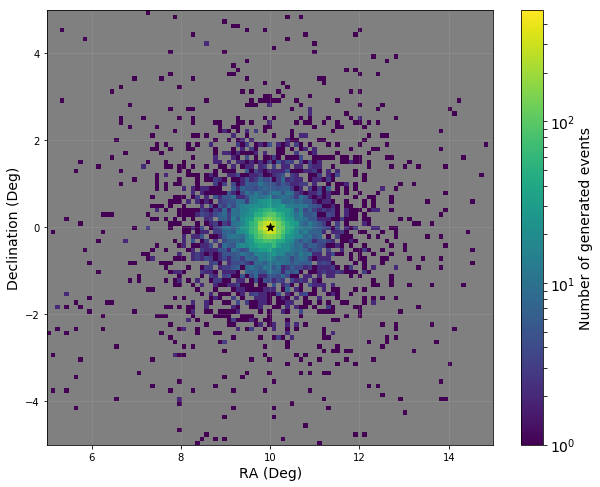

In [11]:
def powerlaw_integral_flux(emin, emax, normalization=1e-12, E0=1000, index=-2):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

# Produce some events from the point source
dec_deg, ra_deg = 0, 10
events = x.generate_pointsource(declination_deg = dec_deg, 
                                right_ascension_deg = ra_deg,
                                integral_flux_function = powerlaw_integral_flux)


# Plot the events
fig, ax = plt.subplots(figsize=(10, 8))
_ = ax.scatter(ra_deg, dec_deg, 
               color='k', 
               marker='*',
               s=64,
               label='Source',
               zorder=100)

ra_bins = np.linspace(ra_deg-5, ra_deg+5, 100)
delta_dec = np.max(np.abs(dec_deg-np.degrees(events['dec'])))
dec_bins = np.linspace(dec_deg-5, dec_deg+5, 100)

h, _, _ = np.histogram2d(np.degrees(events['ra']),
                         np.degrees(events['dec']),
                         bins=(ra_bins, dec_bins))
cmesh = ax.pcolormesh(ra_bins, dec_bins, h.T,
                      norm=LogNorm()
                      )
cbar = plt.colorbar(cmesh, ax=ax)
cbar.ax.set_ylabel('Number of generated events', fontsize=14)
cbar.ax.tick_params(labelsize=14)

ax.grid(alpha=0.25)
ax.set_xlim(ra_bins.min(), ra_bins.max())
ax.set_ylim(dec_bins.min(), dec_bins.max())
ax.set_xlabel("RA (Deg)", fontsize=14)
ax.set_ylabel(r"Declination (Deg)", fontsize=14)

In [12]:
%%timeit 
x.generate_pointsource(declination_deg=0, 
                       right_ascension_deg=10,
                       integral_flux_function = powerlaw_integral_flux)

76.2 ms ± 363 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


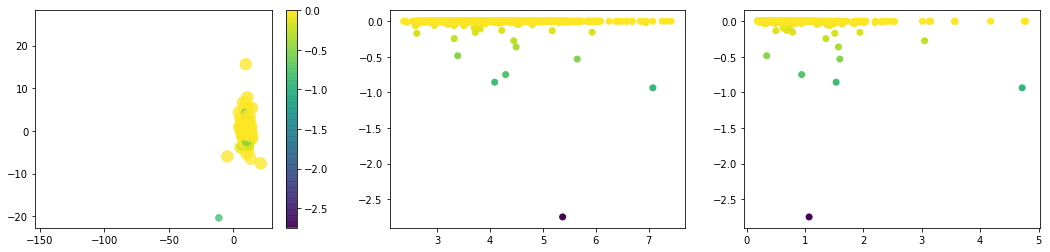

In [13]:
def powerlaw_integral_flux(emin, emax, normalization=1e-13, E0=1000, index=-2):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

events = x.generate_pointsource(declination_deg = dec_deg, 
                                right_ascension_deg = ra_deg,
                                integral_flux_function = powerlaw_integral_flux)
nllh = -1* x.pdf_pointsource(events,
                             declination_deg = dec_deg, 
                             right_ascension_deg = ra_deg,
                             integral_flux_function = powerlaw_integral_flux)

# Plot the likelihood vs each parameter
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

# Left plot: position
alpha = (nllh-np.min(nllh)) / (np.max(nllh)-np.min(nllh))
sca = ax1.scatter(np.degrees(events['ra']),
                    np.degrees(events['dec']),
                    marker='o',
                    s=128 * alpha**3,
                    c=nllh,
                    alpha=0.75)
plt.colorbar(sca, ax=ax1)


# Middle plot: energy
_ = ax2.scatter(events['logE'],
            nllh,
            c=nllh)

# Right plot: sigma?
_ = ax3.scatter(np.degrees(events['sigma']),
            nllh,
            c=nllh)

Text(0,0.5,'Number of astrophysical signal events/bin')

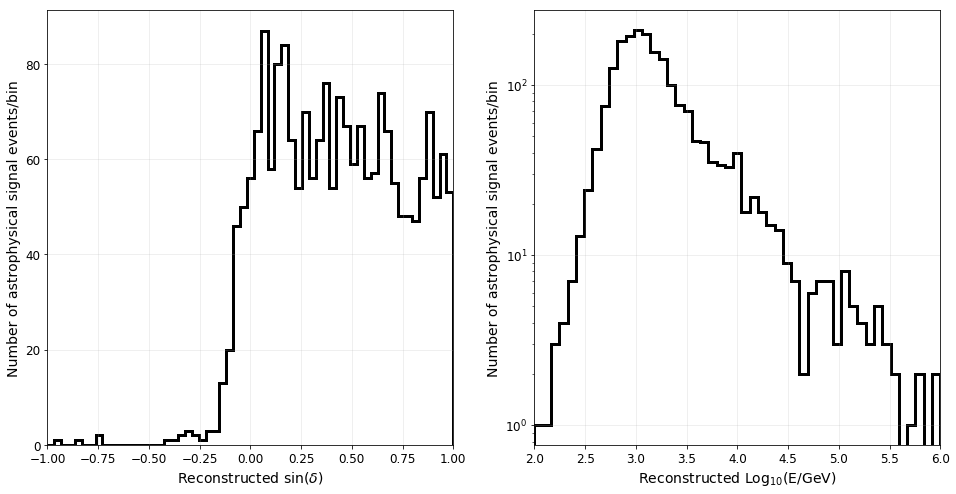

In [20]:
def powerlaw_integral_flux(emin, emax, normalization=1.36e-18, E0=1e5, index=-2.37):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = normalization/E0**index    
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    
    return integral

# Generate the events
events = x.generate_diffuse(integral_flux_function = powerlaw_integral_flux)

# Plot the events
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sindec_bins = np.linspace(-1, 1, 60)
_ = ax1.hist(np.sin(events['dec'].values),
            bins = sindec_bins,
            histtype='step',
            linewidth=3,
            color='k')

loge_bins = np.linspace(2, 6, 50)
_ = ax2.hist(events['logE'].values,
            bins = loge_bins,
            histtype='step',
            linewidth=3,
            color='k')

ax1.grid(alpha=0.25)
ax1.tick_params(labelsize=12)
ax1.set_xlim(sindec_bins.min(), sindec_bins.max())
ax1.set_xlabel(r"Reconstructed sin($\delta$)", fontsize=14)
ax1.set_ylabel(r"Number of astrophysical signal events/bin", fontsize=14)

ax2.grid(alpha=0.25)
ax2.tick_params(labelsize=12)
ax2.set_xlim(loge_bins.min(), loge_bins.max())
ax2.set_yscale('log')
ax2.set_xlabel(r"Reconstructed Log$_{10}$(E/GeV)", fontsize=14)
ax2.set_ylabel(r"Number of astrophysical signal events/bin", fontsize=14)

Text(0,0.5,'Number of astrophysical signal events/bin')

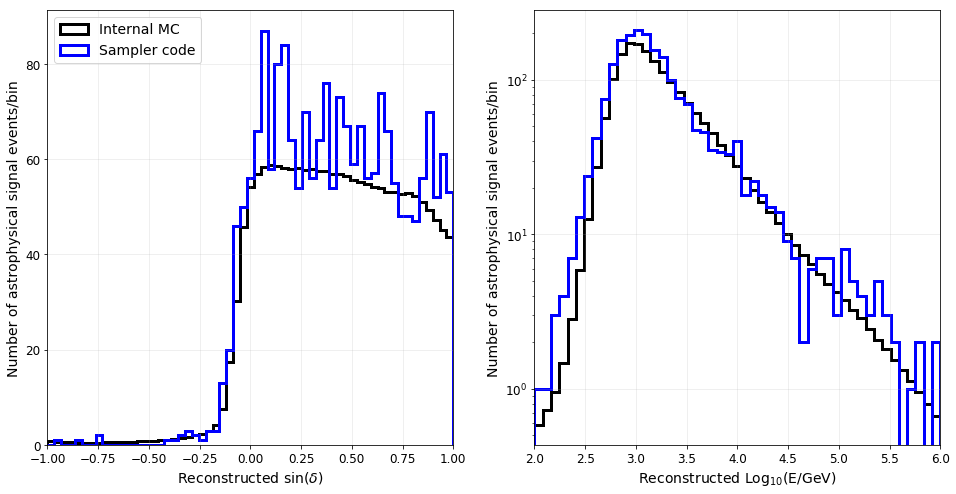

In [23]:
mc = np.load("/data/i3store/users/mjlarson/ps_tracks/IC86_2012_MC.npy")

# Plot the events
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sindec_bins = np.linspace(-1, 1, 60)
_ = ax1.hist(np.sin(mc['dec']),
            bins = sindec_bins,
             weights=mc['ow'] * 1.36e-18*(mc['trueE']/1e5)**(-2.37) * x.total_uptime*24*3600,
            histtype='step',
            linewidth=3,
             label = 'Internal MC',
            color='k')

loge_bins = np.linspace(2, 6, 50)
_ = ax2.hist(mc['logE'],
            bins = loge_bins,
             weights=mc['ow'] * 1.36e-18*(mc['trueE']/1e5)**(-2.37) * x.total_uptime*24*3600,
            histtype='step',
            linewidth=3,
             label = 'Internal MC',
            color='k')

_ = ax1.hist(np.sin(events['dec'].values),
            bins = sindec_bins,
            histtype='step',
             label = 'Sampler code',
            linewidth=3,
            color='b')

_ = ax2.hist(events['logE'].values,
            bins = loge_bins,
            histtype='step',
             label = 'Sampler code',
            linewidth=3,
            color='b')

ax1.legend(loc='upper left', fontsize=14)
ax1.grid(alpha=0.25)
ax1.tick_params(labelsize=12)
ax1.set_xlim(sindec_bins.min(), sindec_bins.max())
ax1.set_xlabel(r"Reconstructed sin($\delta$)", fontsize=14)
ax1.set_ylabel(r"Number of astrophysical signal events/bin", fontsize=14)

ax2.grid(alpha=0.25)
ax2.tick_params(labelsize=12)
ax2.set_xlim(loge_bins.min(), loge_bins.max())
ax2.set_yscale('log')
ax2.set_xlabel(r"Reconstructed Log$_{10}$(E/GeV)", fontsize=14)
ax2.set_ylabel(r"Number of astrophysical signal events/bin", fontsize=14)


In [16]:
x = SignalGenerator(aeffs, smearing, uptime,
                    angular_resolution_scale=1.0)

/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:116: RuntimeWarning: divide by zero encountered in log
  - np.cos(np.radians(smearing['AngErr_max[deg]'])))))


template nside: 128
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


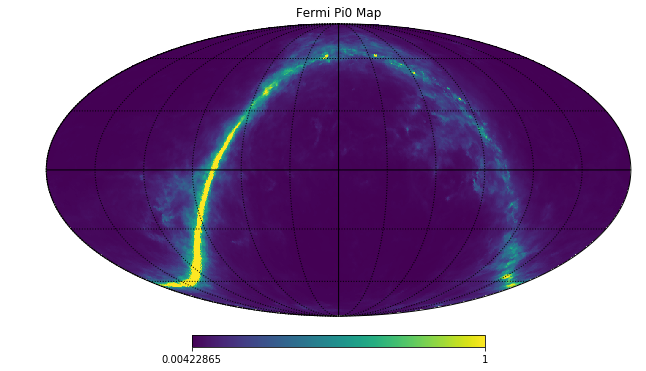

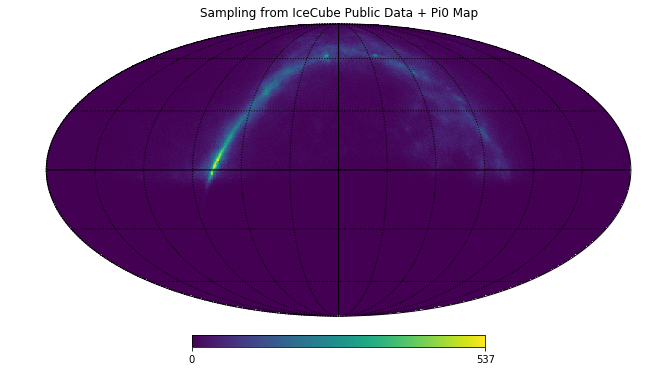

In [17]:
def pi0_powerlaw_integral_flux(map_value, emin, emax, 
                               normalization=4.43e-19, E0=1e5, index=-2.7):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = map_value * normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

# Load a healpix map for testing
pi0_template = np.load("./template.npy")
print('template nside:', hp.npix2nside(len(pi0_template)))
hp.mollview(pi0_template, max=1, flip='geo', title='Fermi Pi0 Map')
hp.graticule(coord='E',)

# Generate events from it and plot them
events = x.generate_from_healpix(pi0_template, pi0_powerlaw_integral_flux)
event_map = bin_to_healpix(128, np.degrees(events['ra']), np.degrees(events['dec']))
hp.mollview(event_map, flip='geo', title='Sampling from IceCube Public Data + Pi0 Map')
hp.graticule(coord='E',)


In [ ]:
%timeit x.generate_from_healpix(pi0_template, pi0_powerlaw_integral_flux)

/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:118: RuntimeWarning: invalid value encountered in log
  - np.cos(np.radians(smearing['PSF_max[deg]'])))))
/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:118: RuntimeWarning: invalid value encountered in logaddexp
  - np.cos(np.radians(smearing['PSF_max[deg]'])))))


template nside: 128
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


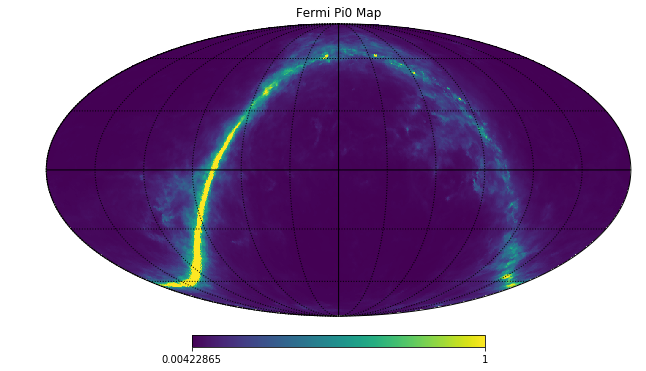

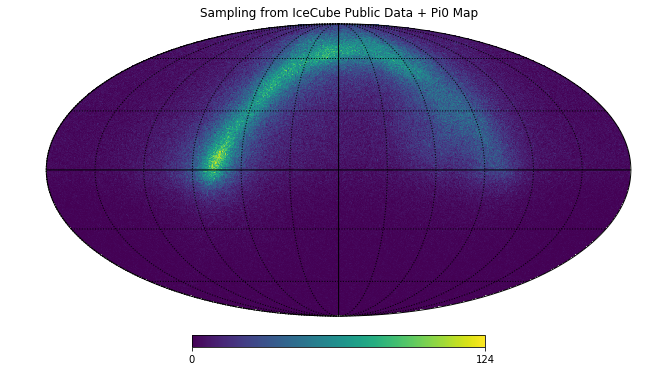

In [19]:
# Test for cascade-like event angular resolutions...
x2 = SignalGenerator(aeffs, smearing, uptime,
                    angular_resolution_scale=15.0)

def pi0_powerlaw_integral_flux(map_value, emin, emax, 
                               normalization=4.43e-19, E0=1e5, index=-2.7):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = map_value * normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

# Load a healpix map for testing
pi0_template = np.load("./template.npy")
print('template nside:', hp.npix2nside(len(pi0_template)))
hp.mollview(pi0_template, max=1, flip='geo', title='Fermi Pi0 Map')
hp.graticule(coord='E',)

# Generate events from it and plot them
events = x2.generate_from_healpix(pi0_template, pi0_powerlaw_integral_flux)
event_map = bin_to_healpix(128, np.degrees(events['ra']), np.degrees(events['dec']))
hp.mollview(event_map, flip='geo', title='Sampling from IceCube Public Data + Pi0 Map')
hp.graticule(coord='E',)
